# Mildly cleaner rewrite of the comparison between LSC and RAW (no threshold) processing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from pathlib import Path
import os
import re
import sys
from tqdm import tqdm

sys.path.append("/gluster/data/next/software/IC_311024/")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
#sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
os.environ['ICTDIR']='/gluster/data/next/software/IC_311024/'

from invisible_cities.io.dst_io        import df_writer
from invisible_cities.io.dst_io        import load_dst

from invisible_cities.cities.beersheba import cut_over_Q
from invisible_cities.cities.beersheba import drop_isolated 


In [2]:
def raw_plotter(q, evt, pitch = 15.55):
    '''
    just plots the hits, nothing smart
    '''

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
    yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
    zz = np.sort(q.Z.unique())

    axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');


    axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    fig.suptitle("rebinned in Z")
    plt.show(fig)



# load in the data

In [3]:
low_thr_files = glob('low_thr/*000[0-9]*')
low_thr_files  = sorted(low_thr_files, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

lsc_run_files = glob('lsc_run/*000[0-9]*')
lsc_run_files = sorted(lsc_run_files, key=lambda f: int(re.search(r'_000(\d)_', f).group(1)))

#print(low_thr_files)
#print(lsc_run_files)


In [4]:
# define cut_over_Q and drop_isolated object
q_thr     = 7
drop_dist = [15.55, 15.55]

cut_sensors   = cut_over_Q(q_thr, ['E', 'Ec'])
drop_sensors  = drop_isolated(drop_dist, ['E', 'Ec'])

# list of evts
evts = [177, 219, 737, 842, 849, 954, 1045, 1087, 1094]

# generate folders to store data
for evt in evts:
    Path(f'evt{evt}_images').mkdir(parents=True, exist_ok=True)

lsc_EOI = []
thr_EOI = []
for lsc_file, thr_file in tqdm(zip(lsc_run_files, low_thr_files)):

    df_lsc = load_dst(lsc_file, 'RECO', 'Events')
    df_thr = load_dst(thr_file, 'RECO', 'Events')
    # extract the events of interest from the df
    df_lsc = df_lsc[df_lsc.event.isin(evts)]
    df_thr = df_thr[df_thr.event.isin(evts)]
    # cut and drop
    #df_lsc  = cut_sensors(df_lsc)
    #df_thr  = cut_sensors(df_thr)
    
    #df_lsc  = drop_sensors(df_lsc)
    #df_thr  = drop_sensors(df_thr)

    lsc_EOI.append(df_lsc)
    thr_EOI.append(df_thr)

    
 # concat
lsc_EOI = pd.concat(lsc_EOI[:2])
thr_EOI = pd.concat(thr_EOI[:2])   

10it [04:46, 28.66s/it]


In [5]:
# kill the screamer
print(lsc_EOI.shape[0])
lsc_EOI = lsc_EOI[~((lsc_EOI.X == 243.225) & (lsc_EOI.Y == -340.975))]
print(lsc_EOI.shape[0])

print(thr_EOI.shape[0])
thr_EOI = thr_EOI[~((thr_EOI.X == 243.225) & (thr_EOI.Y == -340.975))]
print(thr_EOI.shape[0])


16814
16814
7544320
7542215


## initially, noise just over the noise average

Initial hits                             : 877835
Post poissonian cut at 1 PES             : 237252
Efficiency                               : 27.03%


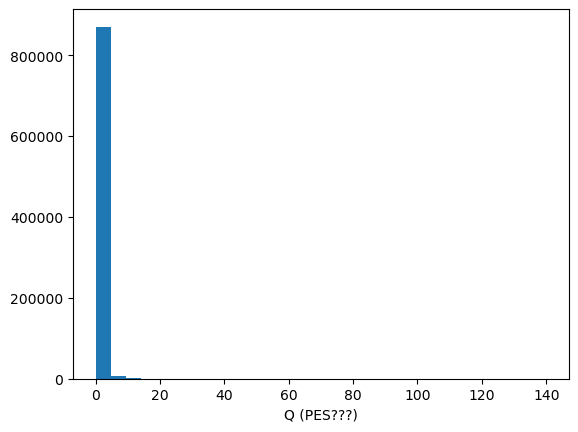

Before cut:


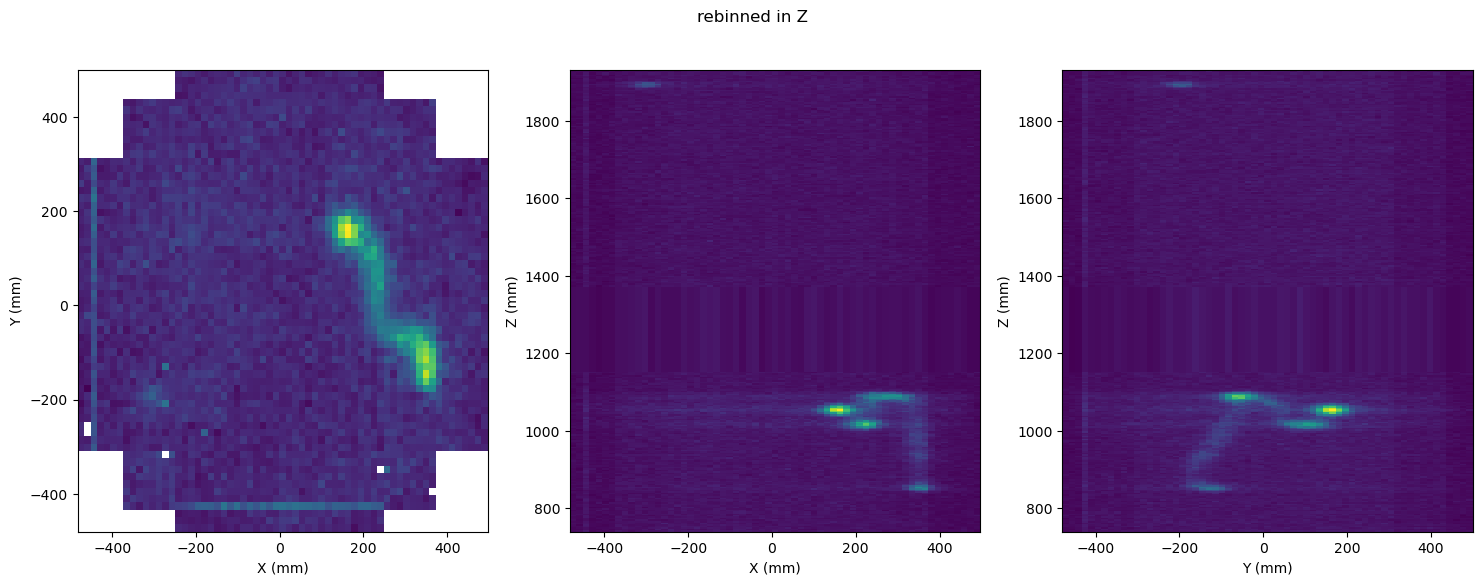

After cut:


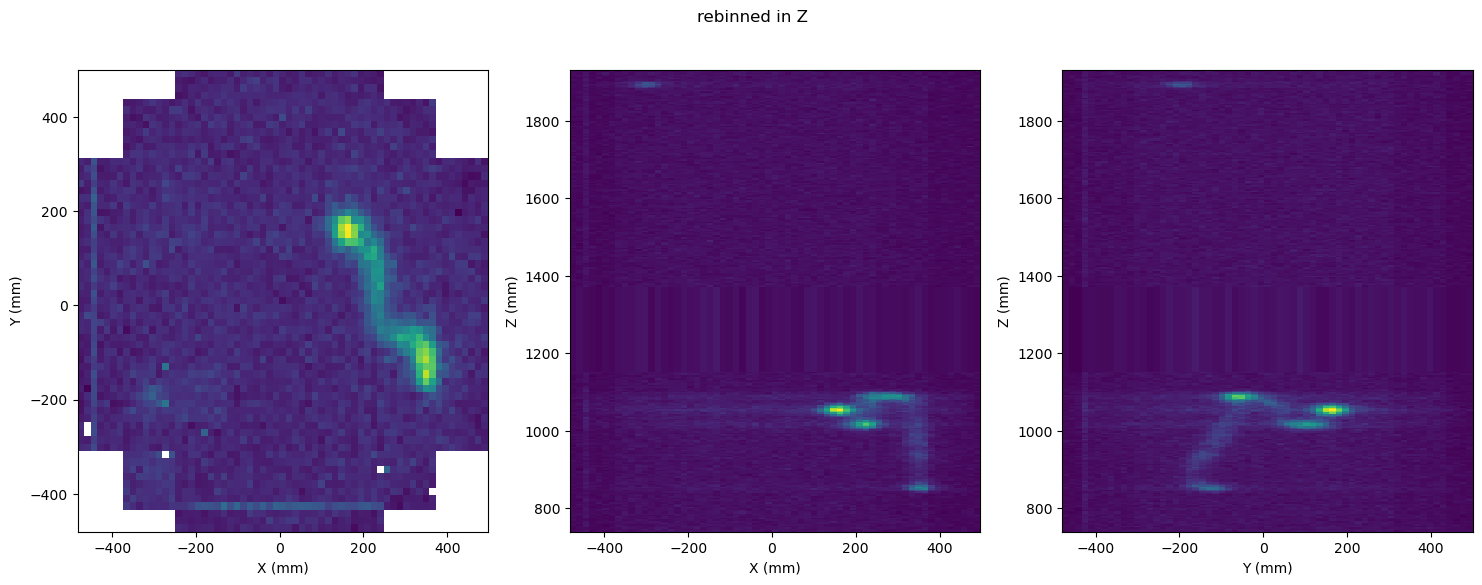

In [6]:
# poissonian sigma, so:

# noise in sipm per mus is ~ 0.07 PEs
# multiply by 4 to get per slice we have ~ 0.28 PEs
pes_per_slice = 0.28 # PEs

noise_cut = 1

lsc_EOI_passing = []

# extract only the hits above 2 sigma
for i, df in thr_EOI.groupby('event'):
    
    
    
    # only keep hits above the noise average
    df_pass = (df[df.Q > noise_cut])
    
    print('='*20)
    print(f'{"Initial hits":<40} : {df.shape[0]}')
    print(f'{"Post poissonian cut at " + str(noise_cut) + " PES":<40} : {df_pass.shape[0]}')
    print(f'{"Efficiency":<40} : {(df_pass.shape[0]/df.shape[0])*100:.2f}%')
    print('='*20)
    plt.hist(df.Q.values, bins = 30)
    plt.xlabel('Q (PES???)')
    plt.show()
    print('Before cut:')
    raw_plotter(df, i)
    print('After cut:')
    raw_plotter(df_pass, i)
    break
    



## look at the section z > 1200

Initial hits                             : 505203
Post poissonian cut at 5.00 PES          : 1453
Efficiency                               : 0.29%


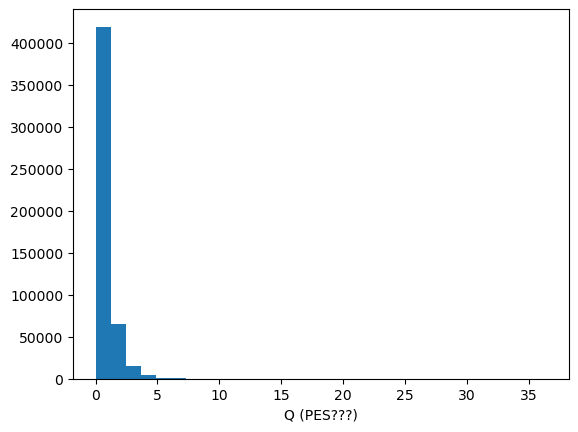

Before cut:


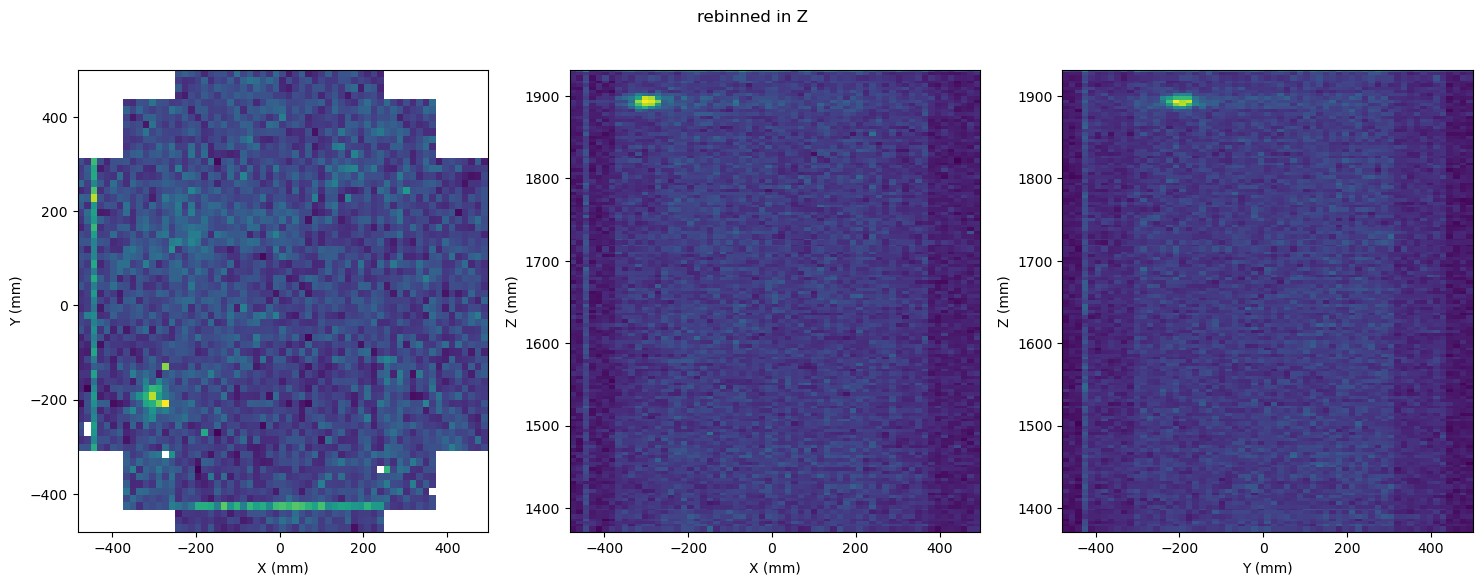

After cut:


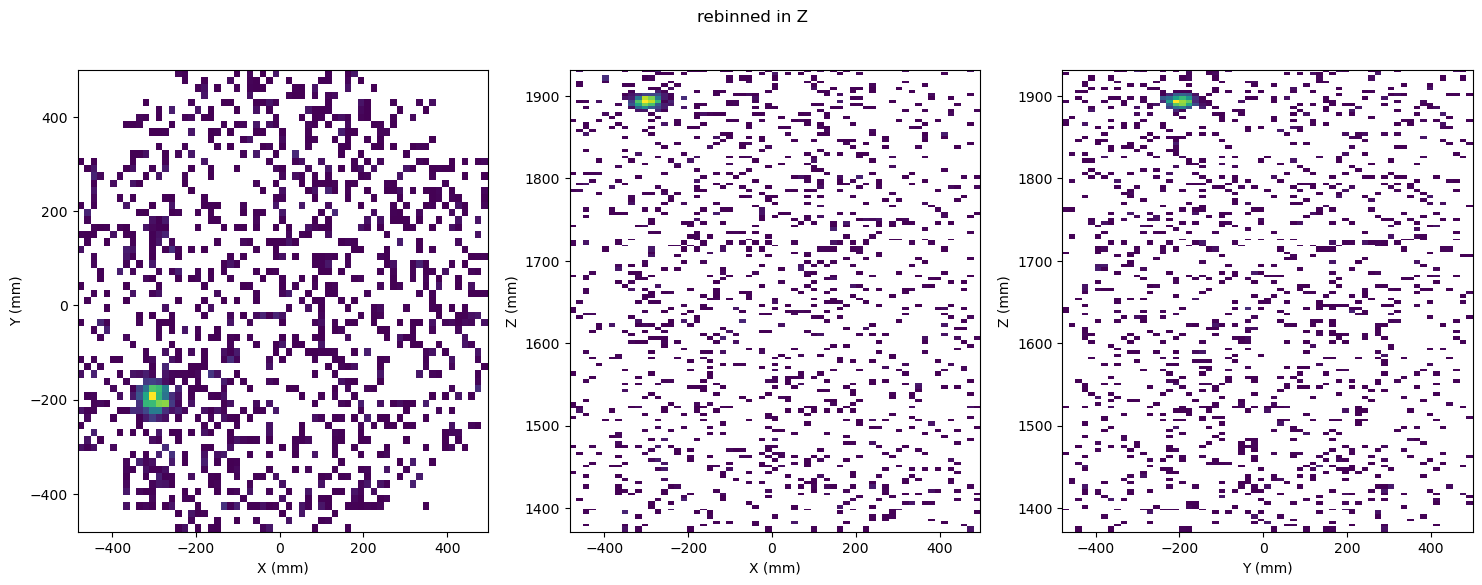

In [7]:
# poissonian sigma, so:

# noise in sipm per mus is ~ 0.07 PEs
# multiply by 4 to get per slice we have ~ 0.28 PEs
pes_per_slice = 0.28 # PEs

# noise would be sqrt of 0.28, which is ~0.5
stdev_pes     = np.sqrt(pes_per_slice)
noise_cut = pes_per_slice + (2* stdev_pes)

noise_cut = 5

lsc_EOI_passing = []

# extract only the hits above 2 sigma
for i, df in thr_EOI.groupby('event'):
    
    # only consider stuff after the event in Z
    df = df[df.Z > 1200]
    
    
    # only keep hits above the noise average
    df_pass = (df[df.Q > noise_cut])
    
    print('='*20)
    print(f'{"Initial hits":<40} : {df.shape[0]}')
    print(f'{"Post poissonian cut at " + f"{noise_cut:.2f}" + " PES":<40} : {df_pass.shape[0]}')
    print(f'{"Efficiency":<40} : {(df_pass.shape[0]/df.shape[0])*100:.2f}%')
    print('='*20)
    plt.hist(df.Q.values, bins = 30)
    plt.xlabel('Q (PES???)')
    plt.show()
    print('Before cut:')
    raw_plotter(df, i)
    print('After cut:')
    raw_plotter(df_pass, i)
    break

In [35]:
# give all xy positions, take a relatively central one
print(df.X.unique())
print(df.Y.unique())

[-482.625 -467.075 -451.525 -435.975 -420.425 -404.875 -389.325 -373.775
 -359.225 -343.675 -328.125 -312.575 -297.025 -281.475 -265.925 -250.375
 -235.825 -220.275 -204.725 -189.175 -173.625 -158.075 -142.525 -126.975
 -112.425  -96.875  -81.325  -65.775  -50.225  -34.675  -19.125   -3.575
   10.975   26.525   42.075   57.625   73.175   88.725  104.275  119.825
  134.375  149.925  165.475  181.025  196.575  212.125  227.675  243.225
  257.775  273.325  288.875  304.425  319.975  335.525  351.075  366.625
  381.175  396.725  412.275  427.825  443.375  458.925  474.475  490.025]
[-294.825 -279.275 -263.725 -248.175 -232.625 -217.075 -201.525 -185.975
 -171.425 -155.875 -140.325 -124.775 -109.225  -93.675  -78.125  -62.575
  -48.025  -32.475  -16.925   -1.375   14.175   29.725   45.275   60.825
   75.375   90.925  106.475  122.025  137.575  153.125  168.675  184.225
  198.775  214.325  229.875  245.425  260.975  276.525  292.075  307.625
 -418.225 -402.675 -387.125 -371.575 -356.025 -340

In [37]:
### take a random xy position, look at its charge values through the detector.

df_xy = df[(df.X == 10.975) & (df.Y == 13.675)]

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
8169984,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1371.003625,0.060857,-0.000212,-1.0,-1.0,-1,-1.0
8173568,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1377.550625,0.060857,-0.000321,-1.0,-1.0,-1,-1.0
8177152,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1380.657000,1.095423,-0.004597,-1.0,-1.0,-1,-1.0
8180736,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1384.357875,0.060857,-0.000024,-1.0,-1.0,-1,-1.0
8184320,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1387.030375,0.121714,-0.000206,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8657408,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1915.855500,0.912853,0.005545,-1.0,-1.0,-1,-1.0
8660992,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1918.865500,0.060857,-0.000096,-1.0,-1.0,-1,-1.0
8664576,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1925.670000,0.060857,-0.000033,-1.0,-1.0,-1,-1.0
8668160,177,1.746555e+09,26,2.257494,8.962107,1,10.975,13.675,0.0,0.0,1928.790500,0.791139,0.000912,-1.0,-1.0,-1,-1.0


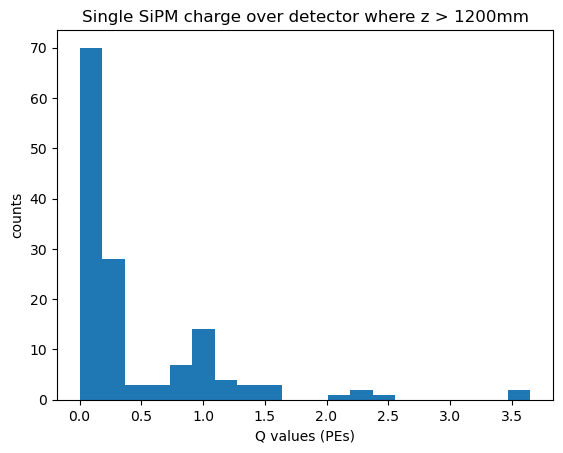

In [43]:
display(df_xy)
plt.hist(df_xy.Q.values, bins = 20)
plt.xlabel('Q values (PEs)')
plt.ylabel('counts')
plt.title('Single SiPM charge over detector where z > 1200mm')
plt.show()


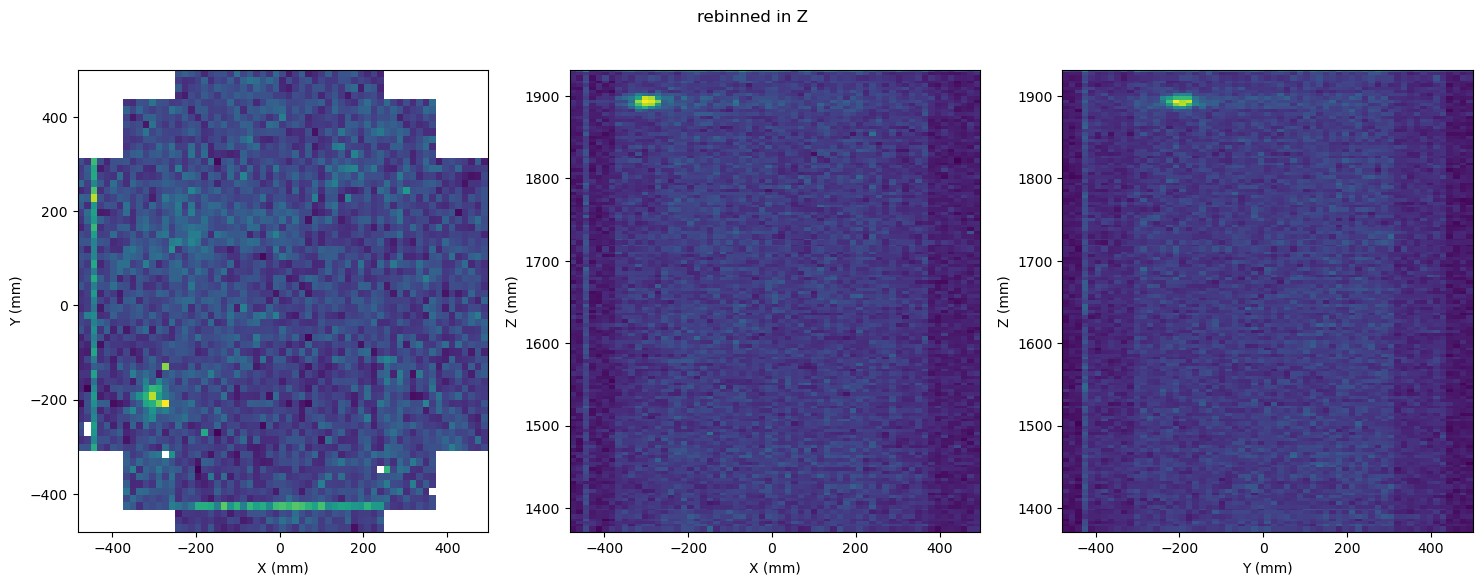

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
8169921,177,1.746555e+09,26,2.257494,8.962107,1,10.975,-94.175,0.0,0.0,1371.003625,0.119565,-0.000417,-1.0,-1.0,-1,-1.0
8169922,177,1.746555e+09,26,2.257494,8.962107,1,10.975,-78.625,0.0,0.0,1371.003625,0.057038,-0.000199,-1.0,-1.0,-1,-1.0
8169923,177,1.746555e+09,26,2.257494,8.962107,1,10.975,-63.075,0.0,0.0,1371.003625,0.244575,-0.000853,-1.0,-1.0,-1,-1.0
8169924,177,1.746555e+09,26,2.257494,8.962107,1,10.975,-47.525,0.0,0.0,1371.003625,0.814688,-0.002843,-1.0,-1.0,-1,-1.0
8169925,177,1.746555e+09,26,2.257494,8.962107,1,10.975,-31.975,0.0,0.0,1371.003625,0.000000,-0.000000,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461819,177,1.746555e+09,26,2.257494,8.962107,1,490.025,245.425,0.0,0.0,1696.205875,1.554154,-0.005485,-1.0,-1.0,-1,-1.0
8461820,177,1.746555e+09,26,2.257494,8.962107,1,490.025,260.975,0.0,0.0,1696.205875,0.277884,-0.000981,-1.0,-1.0,-1,-1.0
8461821,177,1.746555e+09,26,2.257494,8.962107,1,490.025,276.525,0.0,0.0,1696.205875,2.056680,-0.007258,-1.0,-1.0,-1,-1.0
8461822,177,1.746555e+09,26,2.257494,8.962107,1,490.025,292.075,0.0,0.0,1696.205875,0.233337,-0.000823,-1.0,-1.0,-1,-1.0


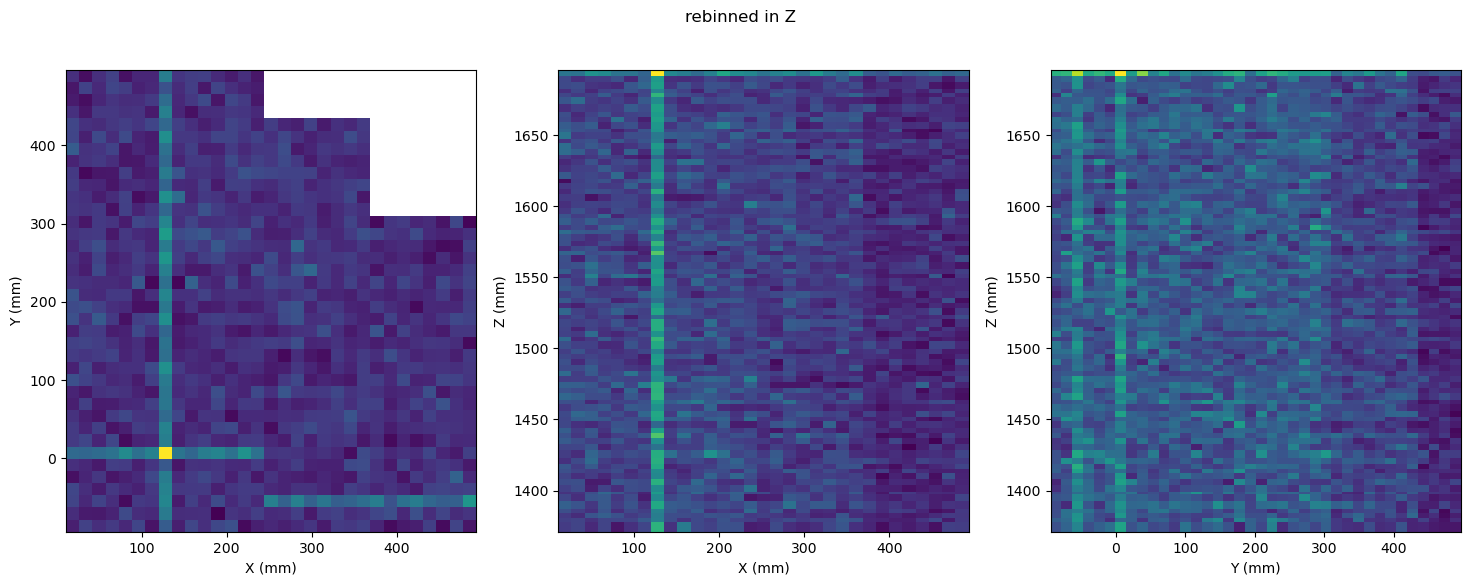

In [9]:
## lets take only the noise area, and consider the noise there

raw_plotter(df, i)

df_nonoise = df[(df.Z < 1700)]
df_nonoise = df_nonoise[df_nonoise.X > 0]
df_nonoise = df_nonoise[df_nonoise.Y > -100]
display(df_nonoise)
raw_plotter(df_nonoise, i)

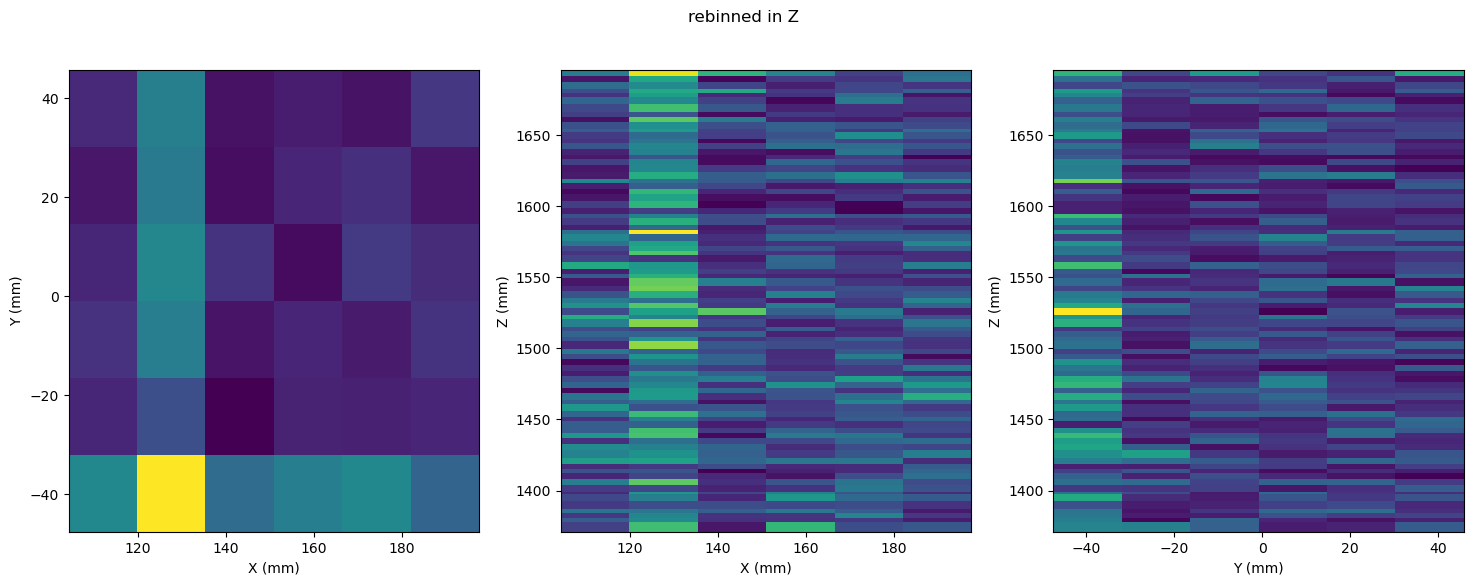

In [10]:
# find this stupid bright spot
df_bs = df_nonoise[df_nonoise.X > 100]
df_bs = df_bs[df_bs.X < 200]
df_bs = df_bs[df_bs.Y < 50]
df_bs = df_bs[df_bs.Y > -50]

raw_plotter(df_bs, i)


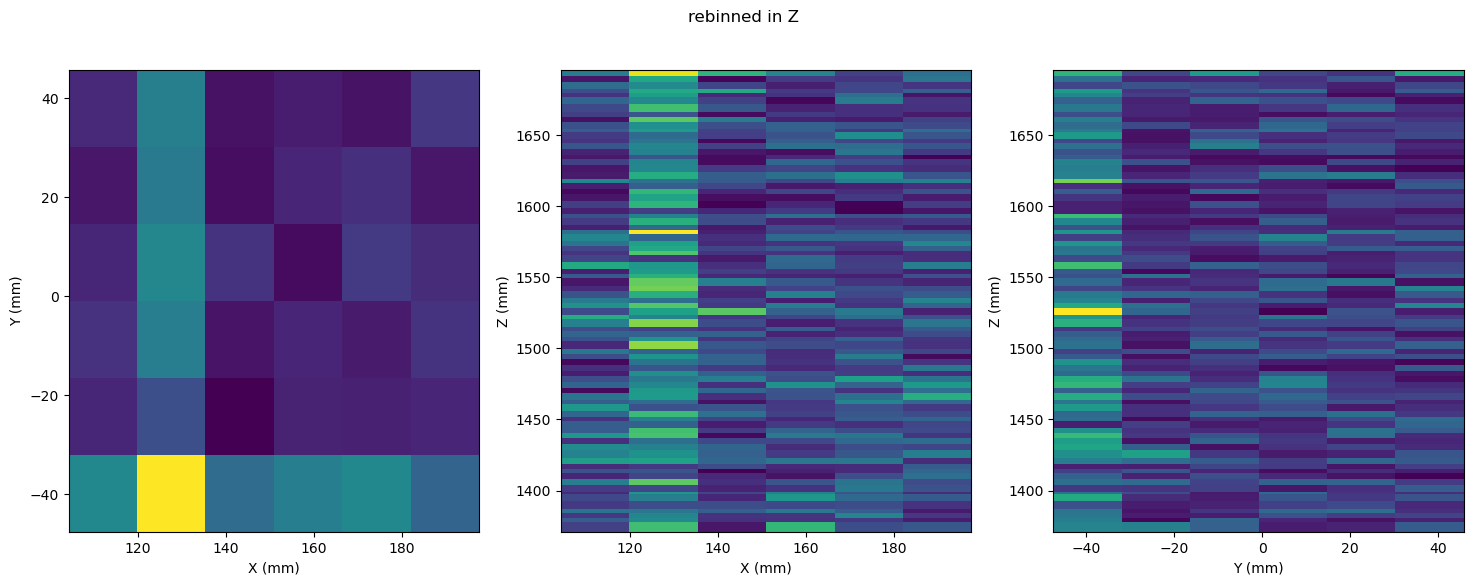

Highest charge of 53.36952167749405 found at XY: 104.275, -47.525
Lowest charge of 53.36952167749405 found at XY: 104.275, -47.525
Highest charge of 64.96269419789314 found at XY: 104.275, -31.975
Lowest charge of 51.549995485693216 found at XY: 104.275, -16.425
Lowest charge of 37.76548420637846 found at XY: 119.825, -47.525
Highest charge of 69.8864292986691 found at XY: 119.825, 44.775
Highest charge of 73.96283006295562 found at XY: 134.375, -47.525
Lowest charge of 32.932613492012024 found at XY: 134.375, -16.425
Lowest charge of 31.282845348119736 found at XY: 149.925, -16.425


In [20]:
# find this stupid bright spot
df_bs = df_nonoise[df_nonoise.X > 100]
df_bs = df_bs[df_bs.X < 200]
df_bs = df_bs[df_bs.Y < 50]
df_bs = df_bs[df_bs.Y > -50]

raw_plotter(df_bs, i)

q_vals = (0, 0, 0)
q_low_vals = (100, 0, 0)
for X, Y in zip(df_bs.X.values, df_bs.Y.values):
    df_bs_xy = df_bs[(df_bs.X == X) & (df_bs.Y == Y)]
    if df_bs_xy.empty:
        continue
    else:
        # find the highest xy val
        if df_bs_xy.Q.sum() > q_vals[0]:
            q_vals = (df_bs_xy.Q.sum(), X, Y)
            print(f'Highest charge of {q_vals[0] } found at XY: {q_vals[1]}, {q_vals[2]}')
        if df_bs_xy.Q.sum() < q_low_vals[0]:
            q_low_vals = (df_bs_xy.Q.sum(), X, Y)
            print(f'Lowest charge of {q_low_vals[0] } found at XY: {q_low_vals[1]}, {q_low_vals[2]}')
        

In [21]:
print(df_bs[(df_bs.X == 134.375) & (df_bs.Y == -47.525)].Q.values)
print(df_bs[(df_bs.X == 134.375) & (df_bs.Y == -47.525)].Q.values.sum())
print("")

print(df_bs[(df_bs.X == 149.925) & (df_bs.Y == -16.425)].Q.values)
print(df_bs[(df_bs.X == 149.925) & (df_bs.Y == -16.425)].Q.values.sum())

[0.4155215  0.17808065 0.17808065 0.29680109 0.11872043 0.3561613
 0.3561613  0.41552153 1.24656451 0.3561613  1.00912368 0.3561613
 0.29680109 1.72144628 0.29680109 0.3561613  0.17808065 2.78993034
 0.29680109 0.23744087 1.42464519 1.06848395 2.43376899 0.89040327
 1.00912368 0.4155215  0.23744087 1.1278441  0.29680109 0.47488174
 2.25568795 0.3561613  2.78993011 0.17808065 0.23744087 0.29680109
 0.17808065 0.53424197 2.37440872 5.28305912 1.30592477 0.05936022
 0.29680109 0.23744087 0.23744087 1.24656463 1.5433656  0.89040327
 1.5433656  0.47488174 0.11872043 0.17808065 0.23744087 0.05936022
 3.62097335 0.23744087 0.05936022 0.11872043 1.36528504 0.29680109
 1.30592465 1.89952695 0.47488174 1.06848383 0.47488174 0.29680109
 0.23744087 0.29680109 1.89952683 0.7716828  1.06848395 0.47488174
 3.26481199 0.29680109 2.78993034 0.7716828  0.89040321 2.84929037
 0.23744087 2.67120981 0.29680109 0.17808065]
73.96283006295562

[0.18657762 0.         0.12438507 1.05727315 0.87069547 0.18657762

In [22]:
import random

def plot_charge_xy(df, x = -9999, y = -9999):
    '''
    plot the charge distribution of any particular xy position (sipm)
    '''
    if (x == -9999) and (y == -9999):
        print('No XY positions selected, choosing at random:')
        df_xy = df[df.X == df.X.unique()[random.randrange(0, df.X.nunique())]]
        df_xy = df_xy[df_xy.X == df_xy.X.unique()[random.randrange(0, df_xy.X.nunique())]]
    else:
        
        df_xy = df[(df.X == x) & (df.Y == y)]
    
    print(f'XY values of ({df_xy.X.unique()[0]}, {df_xy.Y.unique()[1]})')
    print(f'Max Q of {df_xy.Q.max()}')
    
    display(df_xy)
    plt.hist(df_xy.Q.values, bins = 20)
    plt.xlabel('Q values (PEs)')
    plt.ylabel('counts')
    plt.title('Single SiPM charge over detector where z > 1200mm')
    plt.show()

No XY positions selected, choosing at random:
XY values of (427.825, -78.125)
Max Q of 9.071149826049805


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
8171293,177,1.746555e+09,26,2.257494,8.962107,1,427.825,-93.675,0.0,0.0,1371.003625,0.182168,-0.000636,-1.0,-1.0,-1,-1.0
8171294,177,1.746555e+09,26,2.257494,8.962107,1,427.825,-78.125,0.0,0.0,1371.003625,1.920135,-0.006700,-1.0,-1.0,-1,-1.0
8171295,177,1.746555e+09,26,2.257494,8.962107,1,427.825,-62.575,0.0,0.0,1371.003625,0.299238,-0.001044,-1.0,-1.0,-1,-1.0
8171352,177,1.746555e+09,26,2.257494,8.962107,1,427.825,-48.025,0.0,0.0,1371.003625,1.931143,-0.006739,-1.0,-1.0,-1,-1.0
8171353,177,1.746555e+09,26,2.257494,8.962107,1,427.825,-32.475,0.0,0.0,1371.003625,0.235946,-0.000823,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8461787,177,1.746555e+09,26,2.257494,8.962107,1,427.825,245.425,0.0,0.0,1696.205875,0.346919,-0.001224,-1.0,-1.0,-1,-1.0
8461788,177,1.746555e+09,26,2.257494,8.962107,1,427.825,260.975,0.0,0.0,1696.205875,0.111293,-0.000393,-1.0,-1.0,-1,-1.0
8461789,177,1.746555e+09,26,2.257494,8.962107,1,427.825,276.525,0.0,0.0,1696.205875,1.200732,-0.004238,-1.0,-1.0,-1,-1.0
8461790,177,1.746555e+09,26,2.257494,8.962107,1,427.825,292.075,0.0,0.0,1696.205875,0.058326,-0.000206,-1.0,-1.0,-1,-1.0


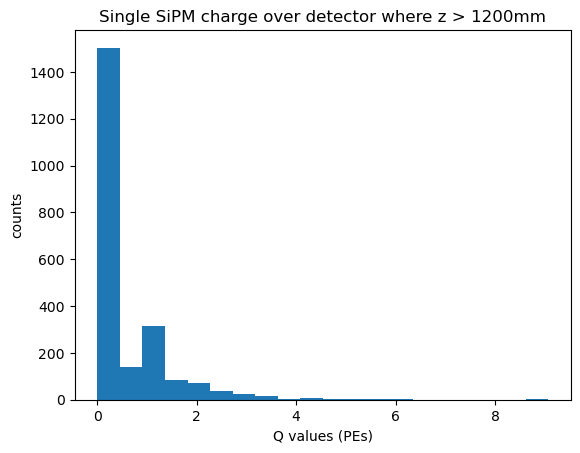

In [23]:
plot_charge_xy(df_nonoise)

## a sideways test, are the charges the same between lsc and thr?

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
7795200,177,1.746555e+09,22,51.369641,10.489568,1,-482.625,-294.825,0.0,0.0,739.245375,0.057027,-0.000207,-1.0,-1.0,-1,-1.0
7795201,177,1.746555e+09,22,51.369641,10.489568,1,-482.625,-279.275,0.0,0.0,739.245375,0.178202,-0.000646,-1.0,-1.0,-1,-1.0
7795202,177,1.746555e+09,22,51.369641,10.489568,1,-482.625,-263.725,0.0,0.0,739.245375,0.289089,-0.001047,-1.0,-1.0,-1,-1.0
7795203,177,1.746555e+09,22,51.369641,10.489568,1,-482.625,-248.175,0.0,0.0,739.245375,2.311669,-0.008374,-1.0,-1.0,-1,-1.0
7795204,177,1.746555e+09,22,51.369641,10.489568,1,-482.625,-232.625,0.0,0.0,739.245375,0.243533,-0.000882,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8673275,177,1.746555e+09,26,2.257494,8.962107,1,490.025,245.425,0.0,0.0,1932.095000,0.115122,-0.000221,-1.0,-1.0,-1,-1.0
8673276,177,1.746555e+09,26,2.257494,8.962107,1,490.025,260.975,0.0,0.0,1932.095000,1.000383,-0.001923,-1.0,-1.0,-1,-1.0
8673277,177,1.746555e+09,26,2.257494,8.962107,1,490.025,276.525,0.0,0.0,1932.095000,0.000000,-0.000000,-1.0,-1.0,-1,-1.0
8673278,177,1.746555e+09,26,2.257494,8.962107,1,490.025,292.075,0.0,0.0,1932.095000,0.000000,-0.000000,-1.0,-1.0,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
12999,177,1.746555e+09,0,114.823133,10.641630,1,-312.575,-402.675,0.0,0.0,832.035625,8.333459,46.687890,-1.0,NaN,-1,-1.0
13000,177,1.746555e+09,0,114.823133,10.641630,1,104.275,-356.525,0.0,0.0,832.035625,10.218158,57.246844,-1.0,0.000315,-1,-1.0
13001,177,1.746555e+09,0,114.823133,10.641630,1,10.975,60.325,0.0,0.0,835.662875,7.198497,152.164455,-1.0,0.000783,-1,-1.0
13002,177,1.746555e+09,0,114.823133,10.641630,1,351.075,-109.225,0.0,0.0,835.662875,7.084815,149.761397,-1.0,0.000816,-1,-1.0
13003,177,1.746555e+09,0,114.823133,10.641630,1,366.625,-109.225,0.0,0.0,835.662875,13.651507,288.570549,-1.0,0.001601,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15275,177,1.746555e+09,1,-154.219031,-96.610473,1,-312.575,-171.425,0.0,0.0,1897.704000,8.463993,70.593019,-1.0,0.000401,-1,-1.0
15276,177,1.746555e+09,1,-154.219031,-96.610473,1,-297.025,-171.425,0.0,0.0,1897.704000,19.919748,166.138508,-1.0,0.000942,-1,-1.0
15277,177,1.746555e+09,1,-154.219031,-96.610473,1,-281.475,-171.425,0.0,0.0,1897.704000,27.342316,228.045629,-1.0,0.001287,-1,-1.0
15278,177,1.746555e+09,1,-154.219031,-96.610473,1,-265.925,-201.525,0.0,0.0,1901.669750,11.378285,231.312493,-1.0,0.001316,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
8673280,219,1.746555e+09,3,8.708352,4.767358,1,-482.625,-294.825,0.0,0.0,-772.960187,0.342161,-0.001720,-1.0,-1.0,-1,-1.0
8673281,219,1.746555e+09,3,8.708352,4.767358,1,-482.625,-279.275,0.0,0.0,-772.960187,0.059401,-0.000299,-1.0,-1.0,-1,-1.0
8673282,219,1.746555e+09,3,8.708352,4.767358,1,-482.625,-263.725,0.0,0.0,-772.960187,0.057818,-0.000291,-1.0,-1.0,-1,-1.0
8673283,219,1.746555e+09,3,8.708352,4.767358,1,-482.625,-248.175,0.0,0.0,-772.960187,0.169147,-0.000850,-1.0,-1.0,-1,-1.0
8673284,219,1.746555e+09,3,8.708352,4.767358,1,-482.625,-232.625,0.0,0.0,-772.960187,0.121766,-0.000612,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9257467,219,1.746555e+09,35,13.668214,57.297454,1,490.025,245.425,0.0,0.0,1837.976250,0.057561,-0.000621,-1.0,-1.0,-1,-1.0
9257468,219,1.746555e+09,35,13.668214,57.297454,1,490.025,260.975,0.0,0.0,1837.976250,0.555769,-0.005994,-1.0,-1.0,-1,-1.0
9257469,219,1.746555e+09,35,13.668214,57.297454,1,490.025,276.525,0.0,0.0,1837.976250,0.241962,-0.002610,-1.0,-1.0,-1,-1.0
9257470,219,1.746555e+09,35,13.668214,57.297454,1,490.025,292.075,0.0,0.0,1837.976250,0.933347,-0.010067,-1.0,-1.0,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
15280,219,1.746555e+09,0,11.426523,-36.482134,1,-50.225,-217.575,0.0,0.0,-1129.149938,8.710958,196.210047,-1.0,0.000944,-1,-1.0
15281,219,1.746555e+09,0,11.426523,-36.482134,1,10.975,-47.525,0.0,0.0,-1125.572656,7.603215,423.503961,-1.0,0.001996,-1,-1.0
15282,219,1.746555e+09,0,11.426523,-36.482134,1,42.075,-78.625,0.0,0.0,-1125.572656,8.765128,488.223256,-1.0,0.002294,-1,-1.0
15283,219,1.746555e+09,0,11.426523,-36.482134,1,10.975,-78.625,0.0,0.0,-1121.734141,16.639120,302.826901,-1.0,0.001435,-1,-1.0
15284,219,1.746555e+09,0,11.426523,-36.482134,1,10.975,-63.075,0.0,0.0,-1121.734141,8.658978,157.590744,-1.0,0.000744,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17391,219,1.746555e+09,5,29.512711,169.585732,1,73.175,276.025,0.0,0.0,1427.228750,11.970171,117.612316,-1.0,0.000650,-1,-1.0
17392,219,1.746555e+09,5,29.512711,169.585732,1,73.175,291.575,0.0,0.0,1427.228750,14.819482,145.608078,-1.0,0.000801,-1,-1.0
17393,219,1.746555e+09,5,29.512711,169.585732,1,73.175,307.125,0.0,0.0,1427.228750,19.015572,186.836547,-1.0,0.001039,-1,-1.0
17394,219,1.746555e+09,5,29.512711,169.585732,1,73.175,322.675,0.0,0.0,1427.228750,9.425932,92.614023,-1.0,0.000514,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
19461120,737,1.746555e+09,8,12.766141,12.468997,1,-482.625,-294.825,0.0,0.0,197.542875,3.592691,-0.022616,-1.0,-1.0,-1,-1.0
19461121,737,1.746555e+09,8,12.766141,12.468997,1,-482.625,-279.275,0.0,0.0,197.542875,0.059401,-0.000374,-1.0,-1.0,-1,-1.0
19461122,737,1.746555e+09,8,12.766141,12.468997,1,-482.625,-263.725,0.0,0.0,197.542875,1.214175,-0.007643,-1.0,-1.0,-1,-1.0
19461123,737,1.746555e+09,8,12.766141,12.468997,1,-482.625,-248.175,0.0,0.0,197.542875,1.635083,-0.010293,-1.0,-1.0,-1,-1.0
19461124,737,1.746555e+09,8,12.766141,12.468997,1,-482.625,-232.625,0.0,0.0,197.542875,0.182650,-0.001150,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20367867,737,1.746555e+09,13,41.107934,-33.680422,1,490.025,245.425,0.0,0.0,1328.851000,0.172684,-0.000630,-1.0,-1.0,-1,-1.0
20367868,737,1.746555e+09,13,41.107934,-33.680422,1,490.025,260.975,0.0,0.0,1328.851000,3.501342,-0.012764,-1.0,-1.0,-1,-1.0
20367869,737,1.746555e+09,13,41.107934,-33.680422,1,490.025,276.525,0.0,0.0,1328.851000,0.000000,-0.000000,-1.0,-1.0,-1,-1.0
20367870,737,1.746555e+09,13,41.107934,-33.680422,1,490.025,292.075,0.0,0.0,1328.851000,0.058334,-0.000213,-1.0,-1.0,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
28975,737,1.746555e+09,0,190.568047,140.828567,1,42.075,477.175,0.0,0.0,217.000500,7.104200,307.722179,-1.0,0.002556,-1,-1.0
28976,737,1.746555e+09,0,190.568047,140.828567,1,227.675,492.725,0.0,0.0,217.000500,7.438631,322.208220,-1.0,NaN,-1,-1.0
28977,737,1.746555e+09,0,190.568047,140.828567,1,319.975,260.975,0.0,0.0,217.000500,8.614173,373.127435,-1.0,0.002144,-1,-1.0
28978,737,1.746555e+09,0,190.568047,140.828567,1,-250.375,-324.925,0.0,0.0,220.799438,7.328235,124.596784,-1.0,0.000728,-1,-1.0
28979,737,1.746555e+09,0,190.568047,140.828567,1,119.825,106.975,0.0,0.0,220.799438,7.228045,122.893330,-1.0,0.000628,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30984,737,1.746555e+09,5,272.704379,196.671247,1,-343.675,-371.575,0.0,0.0,1206.091750,8.173759,32.889545,-1.0,NaN,-1,-1.0
30985,737,1.746555e+09,5,272.704379,196.671247,1,351.075,260.975,0.0,0.0,1206.091750,10.486255,42.194555,-1.0,0.000277,-1,-1.0
30986,737,1.746555e+09,5,272.704379,196.671247,1,366.625,245.425,0.0,0.0,1206.091750,16.206469,65.211532,-1.0,0.000422,-1,-1.0
30987,737,1.746555e+09,5,272.704379,196.671247,1,366.625,260.975,0.0,0.0,1206.091750,12.279106,49.408625,-1.0,0.000341,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
2505216,842,1.746555e+09,7,40.209101,0.251261,1,-482.625,-294.825,0.0,0.0,332.34875,1.881886,-0.002637,-1.0,-1.0,-1,-1.0
2505217,842,1.746555e+09,7,40.209101,0.251261,1,-482.625,-279.275,0.0,0.0,332.34875,0.772210,-0.001082,-1.0,-1.0,-1,-1.0
2505218,842,1.746555e+09,7,40.209101,0.251261,1,-482.625,-263.725,0.0,0.0,332.34875,0.000000,-0.000000,-1.0,-1.0,-1,-1.0
2505219,842,1.746555e+09,7,40.209101,0.251261,1,-482.625,-248.175,0.0,0.0,332.34875,0.056382,-0.000079,-1.0,-1.0,-1,-1.0
2505220,842,1.746555e+09,7,40.209101,0.251261,1,-482.625,-232.625,0.0,0.0,332.34875,0.547949,-0.000768,-1.0,-1.0,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118075,842,1.746555e+09,7,40.209101,0.251261,1,490.025,245.425,0.0,0.0,1010.68050,0.057561,-0.000288,-1.0,-1.0,-1,-1.0
3118076,842,1.746555e+09,7,40.209101,0.251261,1,490.025,260.975,0.0,0.0,1010.68050,0.666922,-0.003339,-1.0,-1.0,-1,-1.0
3118077,842,1.746555e+09,7,40.209101,0.251261,1,490.025,276.525,0.0,0.0,1010.68050,0.120981,-0.000606,-1.0,-1.0,-1,-1.0
3118078,842,1.746555e+09,7,40.209101,0.251261,1,490.025,292.075,0.0,0.0,1010.68050,1.575024,-0.007886,-1.0,-1.0,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3234,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,592.452250,7.585540,400.646677,-1.0,0.002107,-1,-1.0
3235,842,1.746555e+09,0,122.218873,-24.048902,1,273.325,-32.475,0.0,0.0,592.452250,10.329725,545.586761,-1.0,0.002846,-1,-1.0
3236,842,1.746555e+09,0,122.218873,-24.048902,1,273.325,-16.925,0.0,0.0,592.452250,8.365656,441.850193,-1.0,0.002293,-1,-1.0
3237,842,1.746555e+09,0,122.218873,-24.048902,1,288.875,-1.375,0.0,0.0,592.452250,9.624414,508.334246,-1.0,0.002637,-1,-1.0
3238,842,1.746555e+09,0,122.218873,-24.048902,1,134.375,-448.825,0.0,0.0,596.089500,8.835674,117.946335,-1.0,0.000899,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,842,1.746555e+09,0,122.218873,-24.048902,1,458.925,-62.575,0.0,0.0,939.536250,7.687586,83.996732,-1.0,0.000578,-1,-1.0
4831,842,1.746555e+09,0,122.218873,-24.048902,1,443.375,-48.025,0.0,0.0,939.536250,15.959181,174.374513,-1.0,0.001104,-1,-1.0
4832,842,1.746555e+09,0,122.218873,-24.048902,1,443.375,-32.475,0.0,0.0,939.536250,9.758673,106.626012,-1.0,0.000666,-1,-1.0
4833,842,1.746555e+09,0,122.218873,-24.048902,1,458.925,-48.025,0.0,0.0,939.536250,8.375502,91.513094,-1.0,0.000623,-1,-1.0


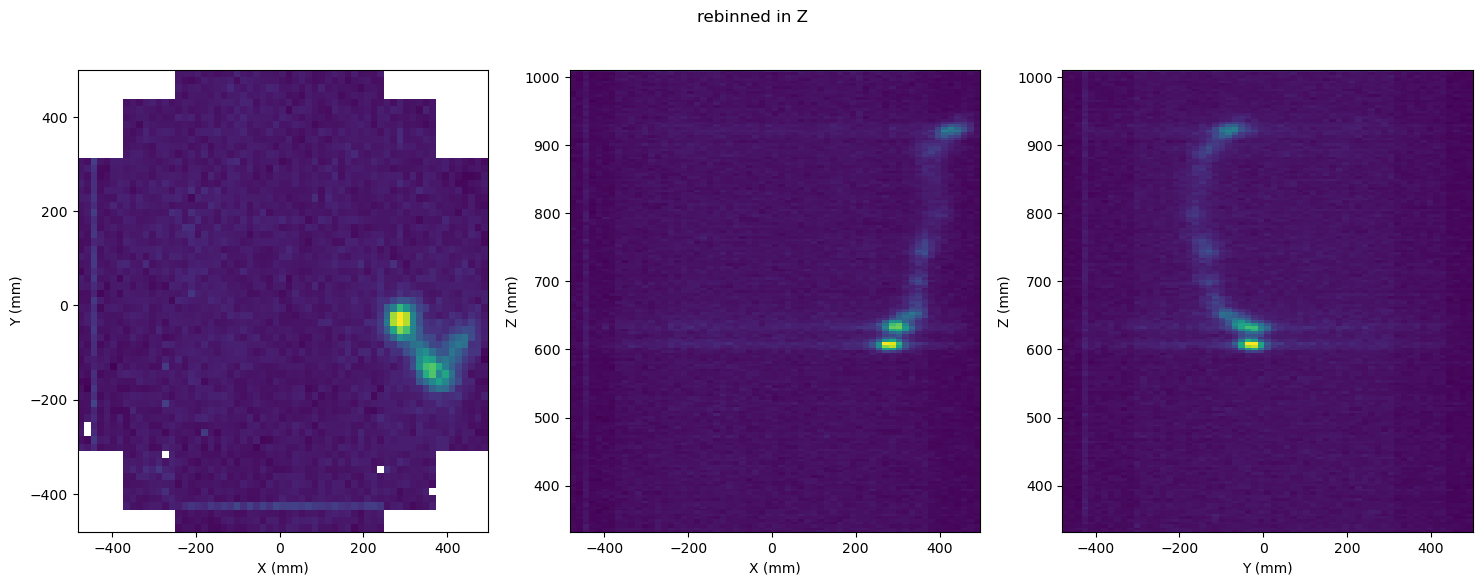

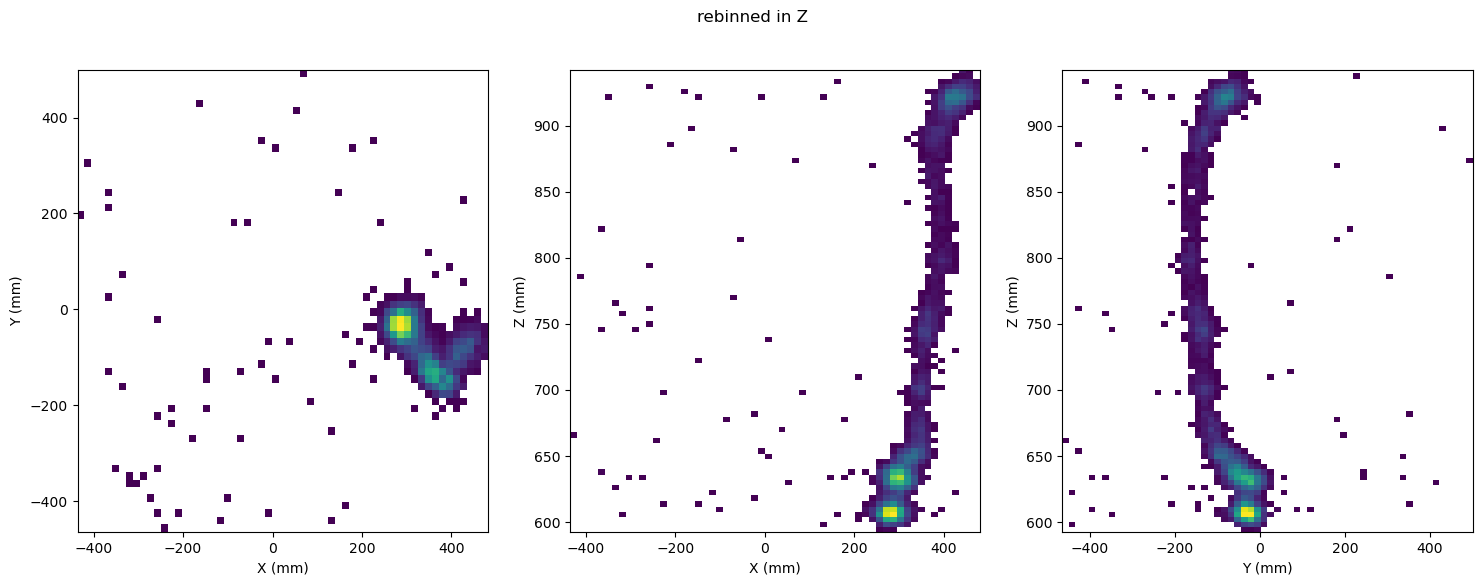

In [93]:
# take both dfs
count = 0
for (i, df_thr), (j, df_lsc) in zip(thr_EOI.groupby('event'), lsc_EOI.groupby('event')):
    
    display(df_thr)
    display(df_lsc)
    count +=1
    if count > 3:
        break

raw_plotter(df_thr, i)
raw_plotter(df_lsc, j)

In [94]:
cut_sensors   = cut_over_Q(7, ['E', 'Ec']) # 7 pes
df_thr = cut_sensors(df_thr)

In [107]:
display(df_thr)
display(df_lsc)
print('Energy per event, thr vs lsc')
print(df_thr.E.sum())
print(df_lsc.E.sum())

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,842,1.746555e+09,7,40.209101,0.251261,1,227.675,446.075,0.0,0.0,335.354125,7.960211,-0.062426,-1.0,-325.900532,-1,-1.0
1,842,1.746555e+09,7,40.209101,0.251261,1,-482.625,229.875,0.0,0.0,338.177500,7.206882,-0.098522,-1.0,-325.900532,-1,-1.0
2,842,1.746555e+09,7,40.209101,0.251261,1,-297.025,168.675,0.0,0.0,343.321750,7.178831,-0.074929,-1.0,-325.900532,-1,-1.0
3,842,1.746555e+09,7,40.209101,0.251261,1,304.425,-217.075,0.0,0.0,347.134750,7.244502,-0.068424,-1.0,-325.900532,-1,-1.0
4,842,1.746555e+09,7,40.209101,0.251261,1,-265.925,-109.225,0.0,0.0,351.297375,8.732862,-0.030831,-1.0,-325.900532,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1875,842,1.746555e+09,7,40.209101,0.251261,1,-3.575,-263.225,0.0,0.0,990.835000,8.710592,-0.235632,-1.0,-325.900532,-1,-1.0
1876,842,1.746555e+09,7,40.209101,0.251261,1,-34.675,-233.125,0.0,0.0,994.724375,8.586865,-0.282366,-1.0,-325.900532,-1,-1.0
1877,842,1.746555e+09,7,40.209101,0.251261,1,-126.975,-294.325,0.0,0.0,1006.677500,9.543359,-0.249731,-1.0,-325.900532,-1,-1.0
1878,842,1.746555e+09,7,40.209101,0.251261,1,-373.775,-279.275,0.0,0.0,1010.680500,7.234324,-0.187253,-1.0,-325.900532,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3234,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,592.452250,7.585540,400.646677,-1.0,0.002107,-1,-1.0
3235,842,1.746555e+09,0,122.218873,-24.048902,1,273.325,-32.475,0.0,0.0,592.452250,10.329725,545.586761,-1.0,0.002846,-1,-1.0
3236,842,1.746555e+09,0,122.218873,-24.048902,1,273.325,-16.925,0.0,0.0,592.452250,8.365656,441.850193,-1.0,0.002293,-1,-1.0
3237,842,1.746555e+09,0,122.218873,-24.048902,1,288.875,-1.375,0.0,0.0,592.452250,9.624414,508.334246,-1.0,0.002637,-1,-1.0
3238,842,1.746555e+09,0,122.218873,-24.048902,1,134.375,-448.825,0.0,0.0,596.089500,8.835674,117.946335,-1.0,0.000899,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,842,1.746555e+09,0,122.218873,-24.048902,1,458.925,-62.575,0.0,0.0,939.536250,7.687586,83.996732,-1.0,0.000578,-1,-1.0
4831,842,1.746555e+09,0,122.218873,-24.048902,1,443.375,-48.025,0.0,0.0,939.536250,15.959181,174.374513,-1.0,0.001104,-1,-1.0
4832,842,1.746555e+09,0,122.218873,-24.048902,1,443.375,-32.475,0.0,0.0,939.536250,9.758673,106.626012,-1.0,0.000666,-1,-1.0
4833,842,1.746555e+09,0,122.218873,-24.048902,1,458.925,-48.025,0.0,0.0,939.536250,8.375502,91.513094,-1.0,0.000623,-1,-1.0


Energy per event, thr vs lsc
368504.8359006961
327791.94586133957


In [96]:
# lets see if we can find a sipm in the same time slice
# matching Z slices first
print(df_lsc.Z.isin(df_thr.Z).any())
# nope!

False


In [97]:
overlap = df_lsc[df_lsc.set_index(['X','Y']).index.isin(df_lsc.set_index(['X','Y']).index)]
display(overlap)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3234,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,592.452250,7.585540,400.646677,-1.0,0.002107,-1,-1.0
3235,842,1.746555e+09,0,122.218873,-24.048902,1,273.325,-32.475,0.0,0.0,592.452250,10.329725,545.586761,-1.0,0.002846,-1,-1.0
3236,842,1.746555e+09,0,122.218873,-24.048902,1,273.325,-16.925,0.0,0.0,592.452250,8.365656,441.850193,-1.0,0.002293,-1,-1.0
3237,842,1.746555e+09,0,122.218873,-24.048902,1,288.875,-1.375,0.0,0.0,592.452250,9.624414,508.334246,-1.0,0.002637,-1,-1.0
3238,842,1.746555e+09,0,122.218873,-24.048902,1,134.375,-448.825,0.0,0.0,596.089500,8.835674,117.946335,-1.0,0.000899,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,842,1.746555e+09,0,122.218873,-24.048902,1,458.925,-62.575,0.0,0.0,939.536250,7.687586,83.996732,-1.0,0.000578,-1,-1.0
4831,842,1.746555e+09,0,122.218873,-24.048902,1,443.375,-48.025,0.0,0.0,939.536250,15.959181,174.374513,-1.0,0.001104,-1,-1.0
4832,842,1.746555e+09,0,122.218873,-24.048902,1,443.375,-32.475,0.0,0.0,939.536250,9.758673,106.626012,-1.0,0.000666,-1,-1.0
4833,842,1.746555e+09,0,122.218873,-24.048902,1,458.925,-48.025,0.0,0.0,939.536250,8.375502,91.513094,-1.0,0.000623,-1,-1.0


In [98]:
# take an xy value in both, and compare the charge at each slice (will differ slightly, 
# but the total should match)
print(df_lsc.X.values)
print(df_lsc.Y.values)

thr_list = list(zip(df_lsc.X.values, df_lsc.Y.values))
lsc_list = list(zip(df_thr.X.values, df_thr.Y.values))
#print(thr_list)
#print(lsc_list)
matches = [t for t in thr_list if t in lsc_list]
print(len(matches))


x_val = matches[0][0]
y_val = matches[0][1]

df_lsc_xy = df_lsc[(df_lsc.X == x_val) & (df_lsc.Y == y_val)]
display(df_lsc_xy)

df_thr_xy = df_thr[(df_thr.X == x_val) & (df_thr.Y == y_val)]
display(df_thr_xy)



[257.775 273.325 273.325 ... 443.375 458.925 443.375]
[ -1.375 -32.475 -16.925 ... -32.475 -48.025 -62.575]
1579


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3234,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,592.452250,7.585540,400.646677,-1.0,0.002107,-1,-1.0
3242,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,596.089500,21.019474,280.586388,-1.0,0.001476,-1,-1.0
3273,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,599.933375,33.816452,388.327628,-1.0,0.002043,-1,-1.0
3317,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,603.721500,54.720119,510.249543,-1.0,0.002685,-1,-1.0
3371,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,607.535875,41.691517,310.583702,-1.0,0.001634,-1,-1.0
3411,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,611.502000,17.892611,138.263407,-1.0,0.000728,-1,-1.0
3441,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,615.706875,7.180206,64.550112,-1.0,0.000340,-1,-1.0
3464,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,619.900125,9.612211,113.685895,-1.0,0.000599,-1,-1.0
3497,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,623.924750,10.596594,125.628594,-1.0,0.000662,-1,-1.0
3601,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-1.375,0.0,0.0,631.674750,13.318124,122.145173,-1.0,0.000643,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
80,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,595.086500,18.317284,173.935207,-1.0,-325.900532,-1,-1.0
107,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,598.993375,27.799866,446.210494,-1.0,-325.900532,-1,-1.0
155,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,602.769625,53.302704,949.216258,-1.0,-325.900532,-1,-1.0
212,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,606.584625,49.533234,700.759769,-1.0,-325.900532,-1,-1.0
261,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,610.473625,22.675739,242.036307,-1.0,-325.900532,-1,-1.0
295,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,614.634625,9.070294,70.785820,-1.0,-325.900532,-1,-1.0
321,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,618.848000,9.541479,85.333948,-1.0,-325.900532,-1,-1.0
354,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,622.969750,10.542746,149.539007,-1.0,-325.900532,-1,-1.0
460,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,630.717125,14.076627,224.875189,-1.0,-325.900532,-1,-1.0
525,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-1.375,0.0,0.0,634.616000,9.482581,130.860577,-1.0,-325.900532,-1,-1.0


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
3240,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,596.089500,12.438423,166.038989,-1.0,0.000874,-1,-1.0
3271,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,599.933375,38.608376,443.355172,-1.0,0.002335,-1,-1.0
3315,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,603.721500,97.967979,913.523531,-1.0,0.004811,-1,-1.0
3369,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,607.535875,78.386703,583.946913,-1.0,0.003076,-1,-1.0
3409,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,611.502000,50.307884,388.749281,-1.0,0.002048,-1,-1.0
3439,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,615.706875,23.337437,209.803743,-1.0,0.001106,-1,-1.0
3462,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,619.900125,13.916256,164.590850,-1.0,0.000867,-1,-1.0
3495,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,623.924750,9.359606,110.963403,-1.0,0.000585,-1,-1.0
3542,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,627.800500,14.162561,143.335544,-1.0,0.000756,-1,-1.0
3599,842,1.746555e+09,0,122.218873,-24.048902,1,257.775,-32.475,0.0,0.0,631.674750,20.073891,184.104674,-1.0,0.000971,-1,-1.0


388.238920211792


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
105,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,598.993375,35.044037,562.485342,-1.0,-325.900532,-1,-1.0
153,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,602.769625,83.657524,1489.775870,-1.0,-325.900532,-1,-1.0
210,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,606.584625,89.446335,1265.420978,-1.0,-325.900532,-1,-1.0
259,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,610.473625,59.693130,637.152538,-1.0,-325.900532,-1,-1.0
293,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,614.634625,28.072577,219.082234,-1.0,-325.900532,-1,-1.0
319,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,618.848000,11.702094,104.657347,-1.0,-325.900532,-1,-1.0
352,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,622.969750,11.390869,161.568848,-1.0,-325.900532,-1,-1.0
396,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,626.810500,12.822508,209.392471,-1.0,-325.900532,-1,-1.0
458,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,630.717125,18.051104,288.367760,-1.0,-325.900532,-1,-1.0
523,842,1.746555e+09,7,40.209101,0.251261,1,257.775,-32.475,0.0,0.0,634.616000,22.097040,304.941386,-1.0,-325.900532,-1,-1.0


392.82935428619385


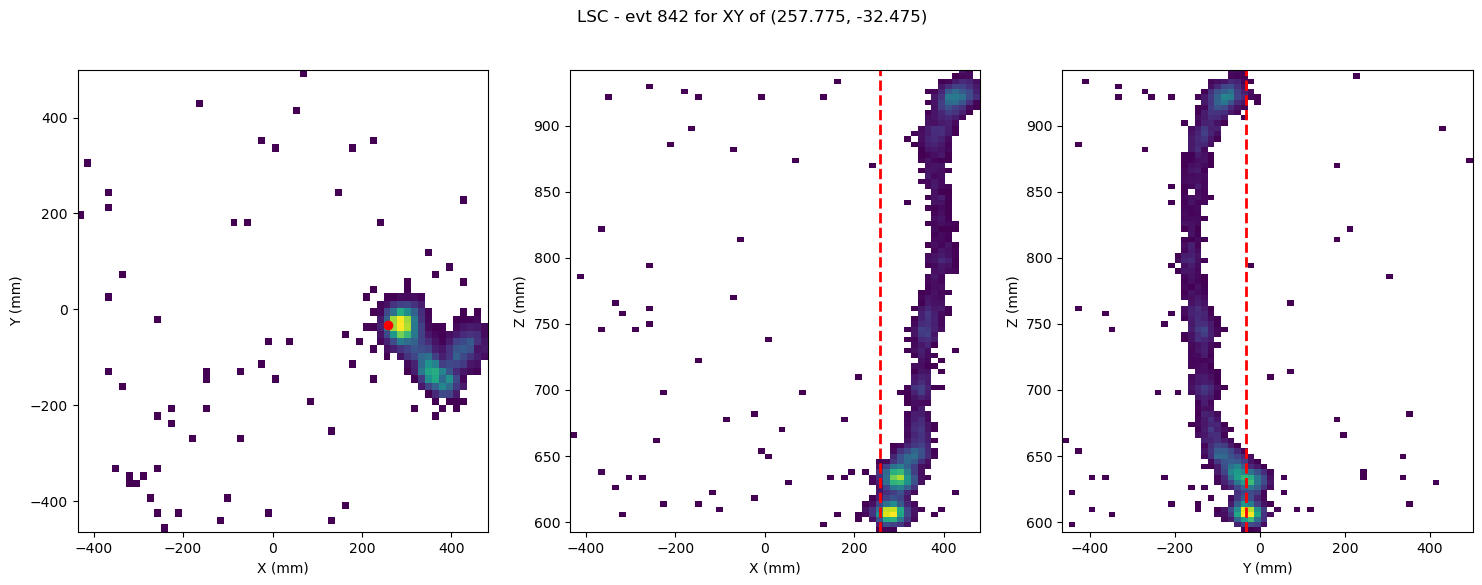

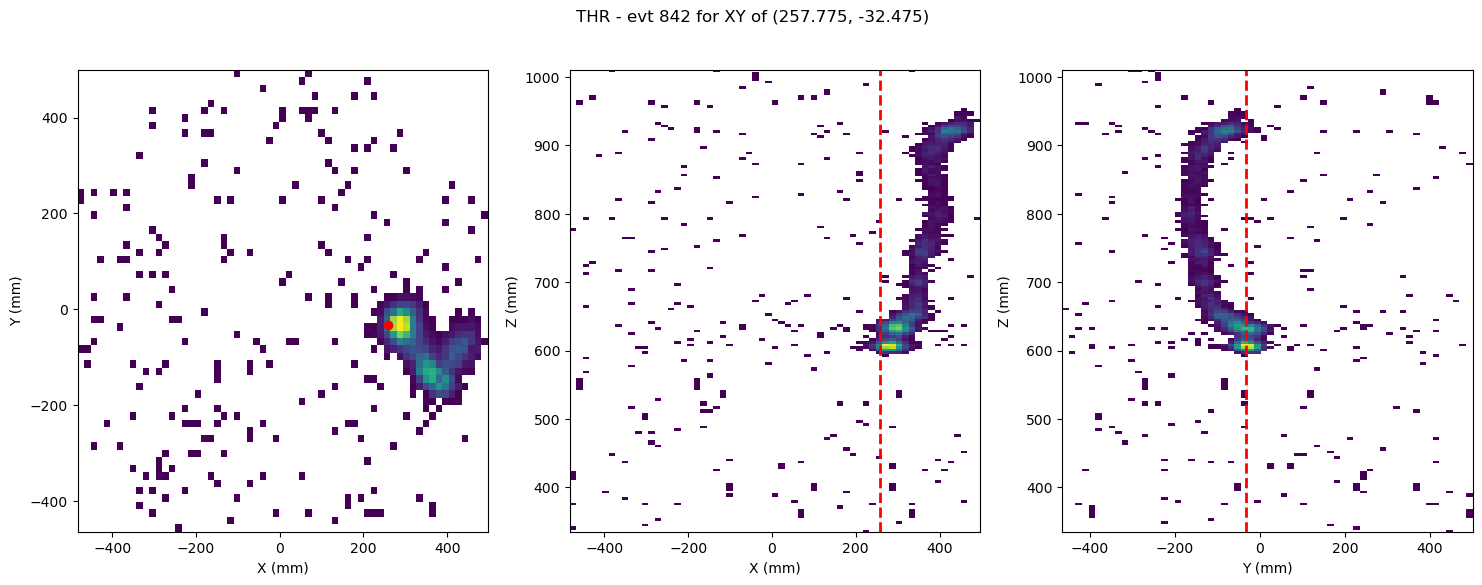

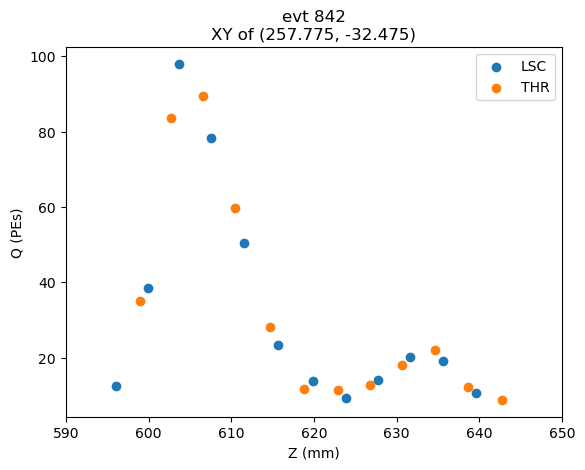

In [124]:
xy_index = 6

x_val = matches[xy_index][0]
y_val = matches[xy_index][1]

df_lsc_xy = df_lsc[(df_lsc.X == x_val) & (df_lsc.Y == y_val)]
display(df_lsc_xy)
print(df_lsc_xy.Q.sum())

df_thr_xy = df_thr[(df_thr.X == x_val) & (df_thr.Y == y_val)]
display(df_thr_xy)
print(df_thr_xy.Q.sum())


q = df_lsc
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.sort(q.Z.unique())

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[0].scatter(x_val, y_val, c = 'red')

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[1].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 

fig.suptitle(f"LSC - evt {q.event.unique()[0]} for XY of {x_val, y_val}")
plt.show(fig)

q = df_thr
pitch = 15.55
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xx = np.arange(q.X.min(), q.X.max() + pitch, pitch)
yy = np.arange(q.Y.min(), q.Y.max() + pitch, pitch)
zz = np.sort(q.Z.unique())

axes[0].hist2d(q.X, q.Y, bins=[xx, yy], weights=q.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[0].scatter(x_val, y_val, c = 'red')

axes[1].hist2d(q.X, q.Z, bins=[xx, zz], weights=q.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[1].axvline(x=x_val, color='red', linestyle='--', linewidth=2) 

axes[2].hist2d(q.Y, q.Z, bins=[yy, zz], weights=q.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
axes[2].axvline(x=y_val, color='red', linestyle='--', linewidth=2) 

fig.suptitle(f"THR - evt {q.event.unique()[0]} for XY of {x_val, y_val}")
plt.show(fig)


plt.scatter(df_lsc_xy.Z.values, df_lsc_xy.Q.values, label = 'LSC')
plt.scatter(df_thr_xy.Z.values, df_thr_xy.Q.values, label = 'THR')
plt.xlabel('Z (mm)')
plt.ylabel('Q (PEs)')
plt.title(f'evt {df_lsc_xy.event.unique()[0]}\nXY of {x_val, y_val}')
plt.xlim([590, 650])
plt.legend()
plt.show()




### surely these pmaps are cooked?

In [82]:


dst_lsc = load_dst(lsc_run_files[0], 'DST', 'Events')
dst_thr = load_dst(low_thr_files[0], 'DST', 'Events')

# select event 177
dst_lsc = dst_lsc[dst_lsc.event == 177]
dst_thr = dst_thr[dst_thr.event == 177]

In [85]:
pd.set_option('display.max_columns', None)
display(dst_lsc)
display(dst_thr)

,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
51,177,1.746555e+09,0,0,1,2,600.0,71.974922,426.122314,390825.0,274.0,5810.121582,412706.875000,115291.523438,1439488.625,723.361023,3516,1048.663696,1048.663696,66.702469,114.823133,10.641630,115.315203,0.092414,235.414110,206.249419
52,177,1.746555e+09,0,1,1,2,600.0,71.974922,426.122314,390825.0,31.4,1246.826660,17249.853516,3816.966064,2280477.750,143.716187,338,1889.652832,1889.652832,5.260881,-154.219031,-96.610473,181.981024,-2.581952,219.854975,208.762290


,event,time,s1_peak,s2_peak,nS1,nS2,S1w,S1h,S1e,S1t,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
38,177,1.746555e+09,0,0,1,2,700.0,72.714867,436.800476,390825.0,390.0,5974.033691,437139.531250,313278.28125,1439488.25,1013.795532,3580,1048.663330,1048.663330,67.118062,51.369641,10.489569,52.429677,0.201429,255.573810,239.748695
39,177,1.746555e+09,0,1,1,2,700.0,72.714867,436.800476,390825.0,559.3,1280.396973,18869.095703,306181.09375,2280478.00,1190.315186,3580,1889.653076,1889.653076,56.478715,2.257494,8.962107,9.242058,1.324037,261.365634,259.938500


In [89]:
# Step 1: Compare
diff_mask = dst_lsc.reset_index(drop=True) != dst_thr.reset_index(drop=True)

# Step 2: Extract only differing columns
differing_columns = diff_mask.any(axis=0)
columns_with_differences = dst_lsc.columns[differing_columns]

# Step 3: Optionally, create DataFrames with only differing columns
lsc_diff = dst_lsc[columns_with_differences]
thr_diff = dst_thr[columns_with_differences]

print("Columns that differ:", list(columns_with_differences))
print("lsc differences:\n")
display(lsc_diff)
print("thr differences:\n")
display(thr_diff)

Columns that differ: ['S1w', 'S1h', 'S1e', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'qmax', 'Nsipm', 'DT', 'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms']
lsc differences:



,S1w,S1h,S1e,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
51,600.0,71.974922,426.122314,274.0,5810.121582,412706.875000,115291.523438,1439488.625,723.361023,3516,1048.663696,1048.663696,66.702469,114.823133,10.641630,115.315203,0.092414,235.414110,206.249419
52,600.0,71.974922,426.122314,31.4,1246.826660,17249.853516,3816.966064,2280477.750,143.716187,338,1889.652832,1889.652832,5.260881,-154.219031,-96.610473,181.981024,-2.581952,219.854975,208.762290


thr differences:



,S1w,S1h,S1e,S2w,S2h,S2e,S2q,S2t,qmax,Nsipm,DT,Z,Zrms,X,Y,R,Phi,Xrms,Yrms
38,700.0,72.714867,436.800476,390.0,5974.033691,437139.531250,313278.28125,1439488.25,1013.795532,3580,1048.663330,1048.663330,67.118062,51.369641,10.489569,52.429677,0.201429,255.573810,239.748695
39,700.0,72.714867,436.800476,559.3,1280.396973,18869.095703,306181.09375,2280478.00,1190.315186,3580,1889.653076,1889.653076,56.478715,2.257494,8.962107,9.242058,1.324037,261.365634,259.938500
